# DS 675 Milestone 4: Age Prediction
## [Video Link](https://youtu.be/KQc-ykOW8mA)
By: Xavier Garay, Aaron Samuel, and Daniel Cwynar

## Objectives
The goal of this project is to create a model that is able to predict the age of an individual using features determined to be the simplest to obtain. The dataset used in the experiment can be found [here](https://www.kaggle.com/datasets/abdullah0a/human-age-prediction-synthetic-dataset/data).

Features will be separated by their ease of collection and reliability by grouping them by their collection methods: physical, survey, and ambiguous. Ambiguous is labeled as such because those features could be found from a simple survey or based on records, but may not have all the information. Surveys are simple to collect but less reliable than physical data, and physical data is further grouped by the ease of collection depending on the feature. Furthermore, features will be separated and trained one by one as to learn more about what each can give to finding the age of a person. More information about which feature is assigned to which group is found later in this report.

### General Description of Dataset
This dataset comprises synthetic data curated for the purpose of age prediction, using a comprehensive suite of health and lifestyle metrics. It features 3,000 records, each with 25 unique attributes, to offer insights into the relationship between various health and lifestyle indicators and age. This dataset is ideally suited for developing predictive models in healthcare and wellness contexts.


## Data and Library Importing

In [ ]:
# Model used for age prediction using the Human Age Prediction Synthetic Dataset on Kaggle (link below)
# Created as a project for course project at New Jersey Institute of Technology
# Data link https://www.kaggle.com/datasets/abdullah0a/human-age-prediction-synthetic-dataset/data

import kagglehub
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Suppress TensorFlow messages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.inspection import permutation_importance
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

In [ ]:
# Pandas dataframe object used as the dataset format

# Download latest version
path = kagglehub.dataset_download("abdullah0a/human-age-prediction-synthetic-dataset") + "/Train.csv"

print("Path to dataset files:", path)
df = pd.read_csv(path)
df.head()

Path to dataset files: /root/.cache/kagglehub/datasets/abdullah0a/human-age-prediction-synthetic-dataset/versions/1/Train.csv


,Gender,Height (cm),Weight (kg),Blood Pressure (s/d),Cholesterol Level (mg/dL),BMI,Blood Glucose Level (mg/dL),Bone Density (g/cm²),Vision Sharpness,Hearing Ability (dB),...,Family History,Cognitive Function,Mental Health Status,Sleep Patterns,Stress Levels,Pollution Exposure,Sun Exposure,Education Level,Income Level,Age (years)
0,Male,171.148359,86.185197,151/109,259.465814,29.423017,157.652848,0.132868,0.200000,58.786198,...,NaN,44.059172,Good,Insomnia,2.797064,5.142344,7.108975,NaN,Medium,89
1,Male,172.946206,79.641937,134/112,263.630292,26.626847,118.507805,0.629534,0.267312,54.635270,...,Heart Disease,45.312298,Good,Normal,9.339930,7.272720,3.918489,Undergraduate,Medium,77
2,Female,155.945488,49.167058,160/101,207.846206,20.217553,143.587550,0.473487,0.248667,54.564632,...,Hypertension,56.246991,Poor,Insomnia,9.234637,8.500386,5.393408,NaN,Medium,70
3,Female,169.078298,56.017921,133/94,253.283779,19.595270,137.448581,1.184315,0.513818,79.722963,...,Hypertension,55.196092,Poor,Insomnia,4.693446,7.555511,2.745578,NaN,Low,52
4,Female,163.758355,73.966304,170/106,236.119899,27.582078,145.328695,0.434562,0.306864,52.479469,...,NaN,53.023379,Good,Normal,4.038537,9.429097,3.878435,Undergraduate,High,79


As shown in this section, there are many features, which will be grouped by collection method:

| Physical                     | Survey                  | Ambiguous          |
|------------------------------|-------------------------|--------------------|
| Height (cm)                  | Physical Activity Level | Medication Use     |
| Weight (kg)                  | Smoking Status          | Chronic Diseases   |
| Blood Pressure (s/d in mmHg) | Alcohol Consumption     | Family History     |
| Cholesterol Level (mg/dL)    | Diet                    | Cognitive Function |
| Body Mass Index (BMI)        | Sleep Patterns (Hours)  |                    |
| Blood Glucose Level (mg/dL)  | Mental Health Status    |                    |
| Bone Density (g/cm2)         | Stress Levels           |                    |
| Hearing Ability (dB)         | Pollution Exposure      |                    |
| Vision Sharpness             | Sun Exposure (Hours)    |                    |
|                              | Education Level         |                    |

> All the sections will include the **Gender** feature, as there may be physiological differences that a predictor would need to consider during analysis

> The **Ambiguous** category is labeled as such because it could be a simple survey or based on records, but could not have all the information (e.g., Family History might not fully encompass all the diseases/disorders experienced by family members)

The **Physical** section is further separated into how difficult it is to collect the information:

| Easy                         | Moderate                    | Difficult            |
|------------------------------|-----------------------------|----------------------|
| Height (cm)                  | Blood Glucose Level (mg/dL) | Bone Density (g/cm2) |
| Weight (kg)                  | Cholesterol Level (mg/dL)   |                      |
| Blood Pressure (s/d in mmHg) | Hearing Ability (dB)        |                      |
| Body Mass Index (BMI)        | Vision Sharpness            |                      |

> **Easy** can be done by people at home, **Moderate** can be done with a simple doctor's appointment, and **Difficult** requires an X-Ray or more complicated procedures.






## Data Preprocessing

### Pruning
Ensuring all values are numerical instead of categorical is important for actual use in the regression models.

In [ ]:
def prune_data(df) -> [pd.DataFrame, dict[str, dict[str, int]]]:
    """
    Cleans and preprocesses the given DataFrame.

    This function performs several operations on the DataFrame:
    1. Replaces null values with the string 'None'.
    2. Splits the 'Blood Pressure (s/d)' column into 'Systolic_BP' and 'Diastolic_BP' columns.
    3. Converts non-numerical (categorical) values into numerical values and maps them.

    Parameters:
    df (pd.DataFrame): The input DataFrame to be pruned.

    Returns:
    df (pd.DataFrame): The cleaned and preprocessed DataFrame.
    category_values (dict): A dictionary mapping each non-numerical column to its corresponding value mapping.
    """

    # Replace null values with string None
    df.fillna('None', inplace=True)

    # Separate 'Blood Pressure (s/d)'
    df[['Systolic_BP', 'Diastolic_BP']] = df['Blood Pressure (s/d)'].str.split('/', expand=True).astype(float)
    df.drop(columns='Blood Pressure (s/d)', inplace=True)

    # Correct order of columns to have Blood Pressure values back where the original was
    current_columns = df.columns.tolist()
    new_order = current_columns[:3] + ['Systolic_BP', 'Diastolic_BP'] + current_columns[3:-2]
    df = df[new_order]

    # Convert non-numerical values to numerical
    category_values = {}
    for col in df.select_dtypes(exclude=[np.number]).columns:
        categories = df[col].unique()
        value_map = {value: idx for idx, value in enumerate(categories)}
        df[col] = df[col].map(value_map).astype('category')
        category_values[col] = value_map

    return df, category_values



df, category_values = prune_data(df)

### Normalization and Data Split
The data is normalized for easier processing of the data. Data is then randomly split into training and test sets.

In [ ]:
def normalize_data(df) -> pd.DataFrame:
    """
    Normalizes all columns in the DataFrame using MinMaxScaler.
    All features are numerical before this point.

    Parameters:
    df (pd.DataFrame): The input DataFrame to be normalized.

    Returns:
    df (pd.DataFrame): The normalized DataFrame.
    """

    scaler = MinMaxScaler()
    normalized_array = scaler.fit_transform(df)

    return pd.DataFrame(normalized_array, columns=df.columns, index=df.index)

df_norm = normalize_data(df)

X = df_norm.drop(columns=['Age (years)'])
y = df_norm['Age (years)']
X_train, X_test, y_train, y_test = train_test_split(X, y)


### Group sets
Separate the data into subsets based on the categories described before.

In [ ]:
def group_sets(col_names: list[str]):
    """
    Group the features into sets given the column names.

    Parameters:
    col_names (list[str]): The column header names to group by.

    Returns:
    Group_X_train (pd.DataFrame): The grouped training features.
    Group_X_test (pd.DataFrame): The grouped test features.
    """
    Group_X_train = []
    Group_X_test = []

    for name in col_names:
      Group_X_train.append(X_train[name])
      Group_X_test.append(X_test[name])

    Group_X_train = pd.DataFrame(Group_X_train).transpose()
    Group_X_test = pd.DataFrame(Group_X_test).transpose()

    return Group_X_train, Group_X_test

Physical = {}
Physical['Easy'] = group_sets([
    'Height (cm)',
    'Weight (kg)',
    'BMI',
    'Systolic_BP',
    'Diastolic_BP',
    'Gender'
])
Physical['Moderate'] = group_sets([
    'Cholesterol Level (mg/dL)',
    'Blood Glucose Level (mg/dL)',
    'Hearing Ability (dB)',
    'Vision Sharpness',
    'Gender'
])
Physical['Difficult'] = group_sets([
    'Bone Density (g/cm²)',
    'Gender'
])

Survey = group_sets([
    'Physical Activity Level',
    'Smoking Status',
    'Sleep Patterns',
    'Mental Health Status',
    'Stress Levels',
    'Diet',
    'Pollution Exposure',
    'Sun Exposure',
    'Education Level',
    'Alcohol Consumption',
    'Gender'
])

Ambiguous = group_sets([
    'Medication Use',
    'Chronic Diseases',
    'Cognitive Function',
    'Family History',
    'Gender'
])

## Data Visualization
To visualize the data, we will generate several visualizations for the given DataFrame, including:
1. Bar charts for categorical columns based on the category map.
2. Histograms with KDE plots for all numerical columns.
3. A correlation matrix heatmap.
4. Box plot to visualize outliers

To begin, we will ensure the graph labels are correct by using the category_values object from earlier.

### Bar Charts for Categorical Columns
The bar charts show that the data is somewhat preferred towards some values in many features, which could introduce some bias to our models. However, this is a risk we are willing to take as the data seems to represent the population well.

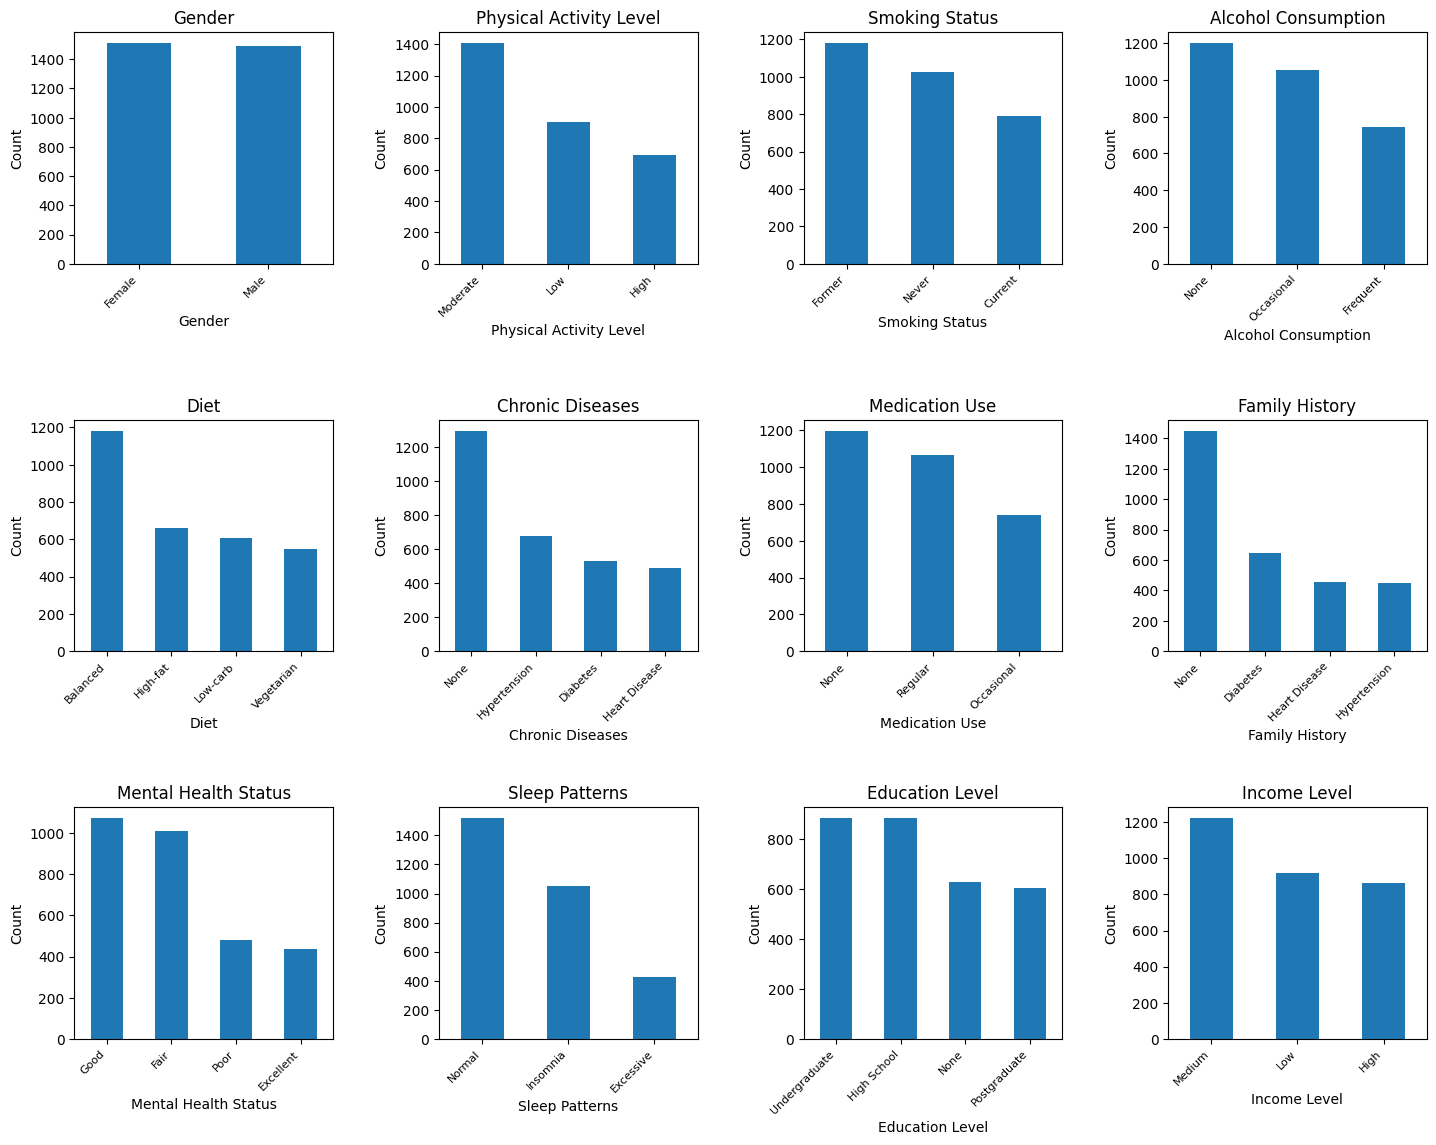

In [ ]:
plt.figure(figsize=(15, 15))

for i, category_name in enumerate(category_values):
    # Flip category map
    val = {v: k for k, v in category_values[category_name].items()}

    plt.subplot(4, 4, i+1)
    df[category_name].map(val).value_counts().plot(kind='bar')
    plt.title(category_name)
    plt.xlabel(category_name)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right', fontsize=8)

plt.tight_layout(pad=3)
plt.show()

### Histogram with KDE Plots for all Numerical Columns
The histograms show that many of the numerical features follow a bell curve in their distribution, with some being relatively even across the values, and one (vision sharpness) that was heavily skewed towards the left. To us, this makes the dataset viable for use as a training set.

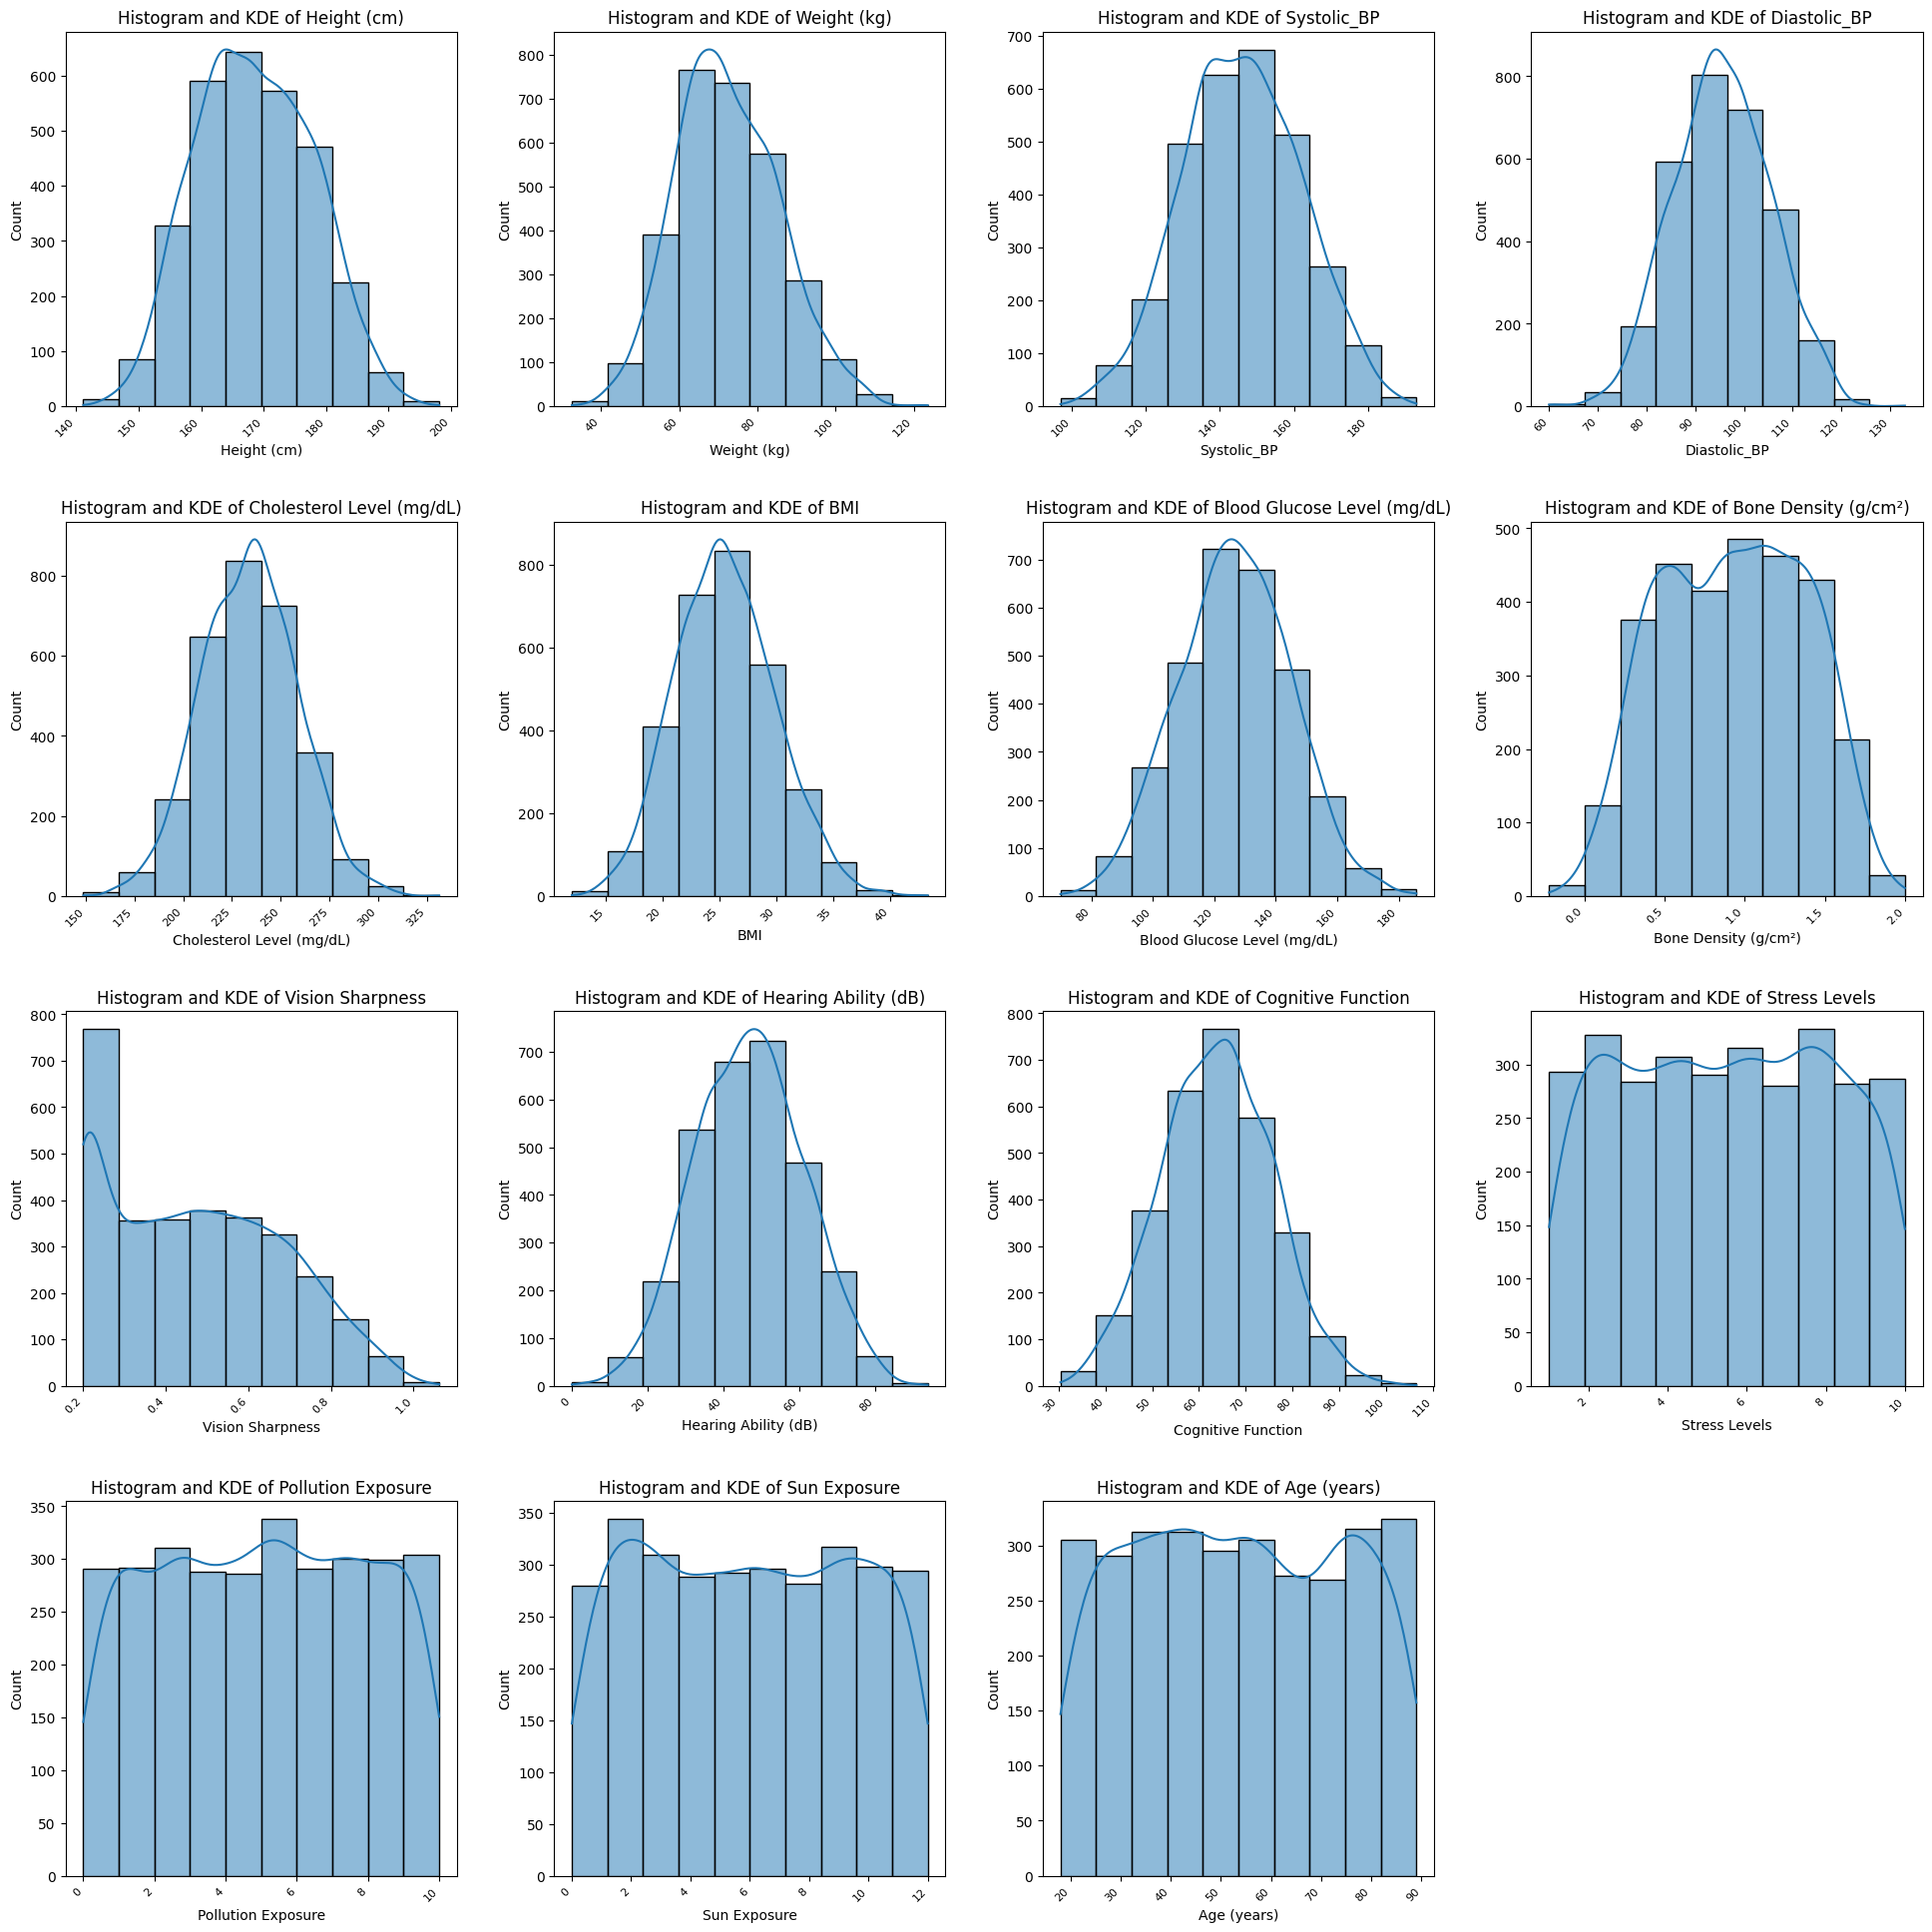

In [ ]:
# Histograms for all numerical columns
plt.figure(figsize=(20, 20))
for i, column in enumerate(df.select_dtypes(include=[np.number]).columns):
  plt.subplot(4, 4, i + 1)
  sns.histplot(df[column], kde=True, bins=10)
  plt.title(f'Histogram and KDE of {column}')
  plt.xlabel(column)
  plt.ylabel('Count')
  plt.xticks(rotation=45, ha='right', fontsize=8)
plt.tight_layout(pad=3)
plt.show()

### Correlation Matrix Heatmap
This graph shows that some features are highly correlated, which we will keep in mind as we train the models. We also kept the age label in this matrix, as we can already see some values with noticeably high correlation with age like bone density, vision sharpness, and hearing ability.

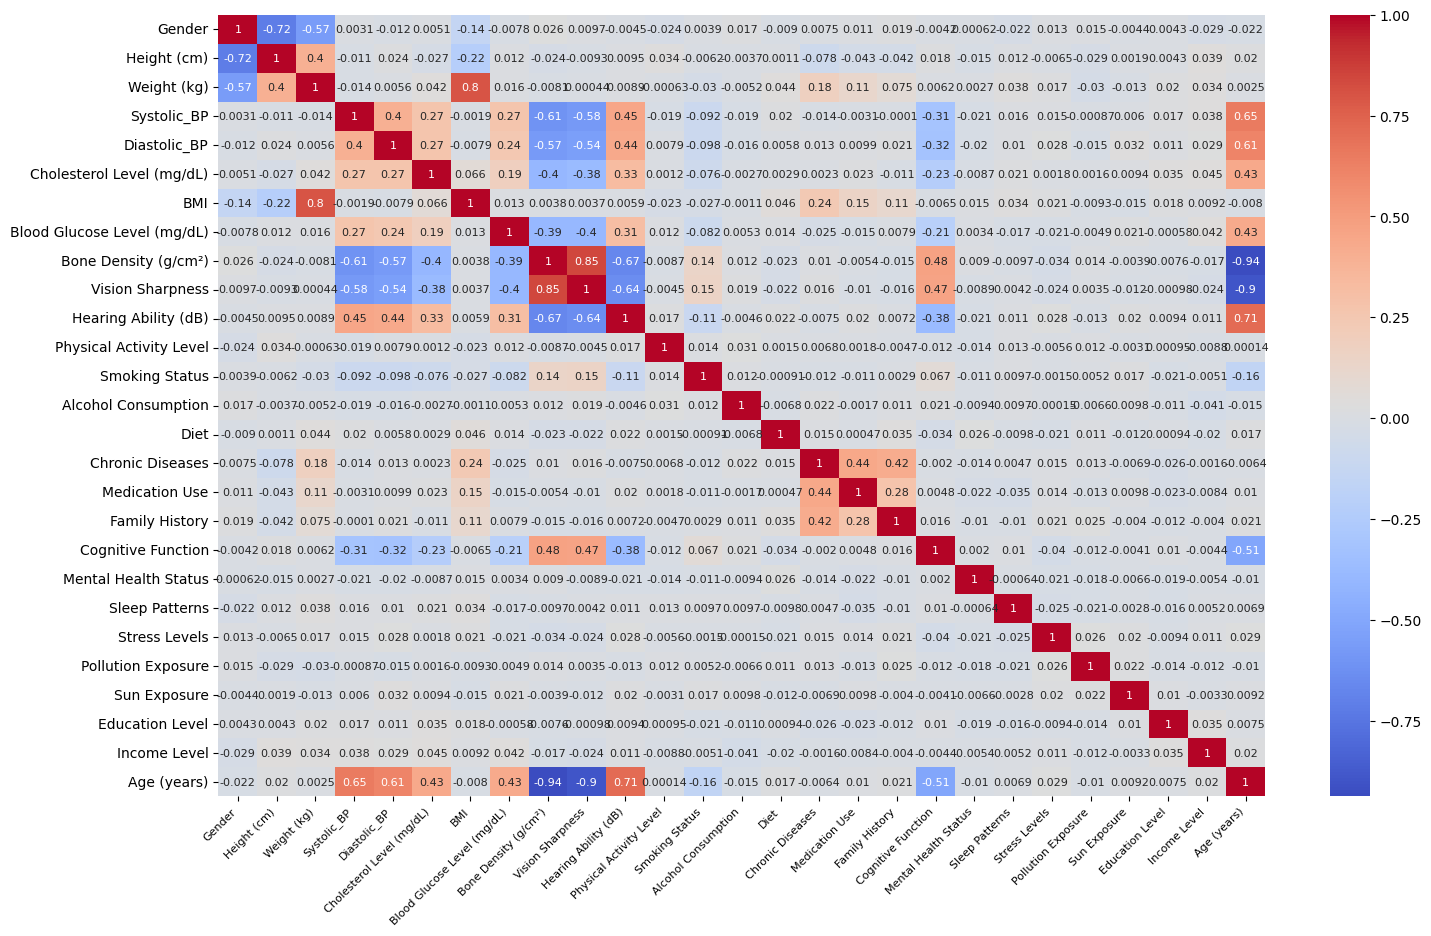

In [ ]:
# Display correlation matrix
plt.figure(figsize=(16, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', annot_kws={"size": 8})
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.tight_layout(pad=3)
plt.show()

### Box Plot to Visualize Outliers
These plots show that there are some features that contain many outliers, but not so many that we believe would skew the results enough to consider removal.

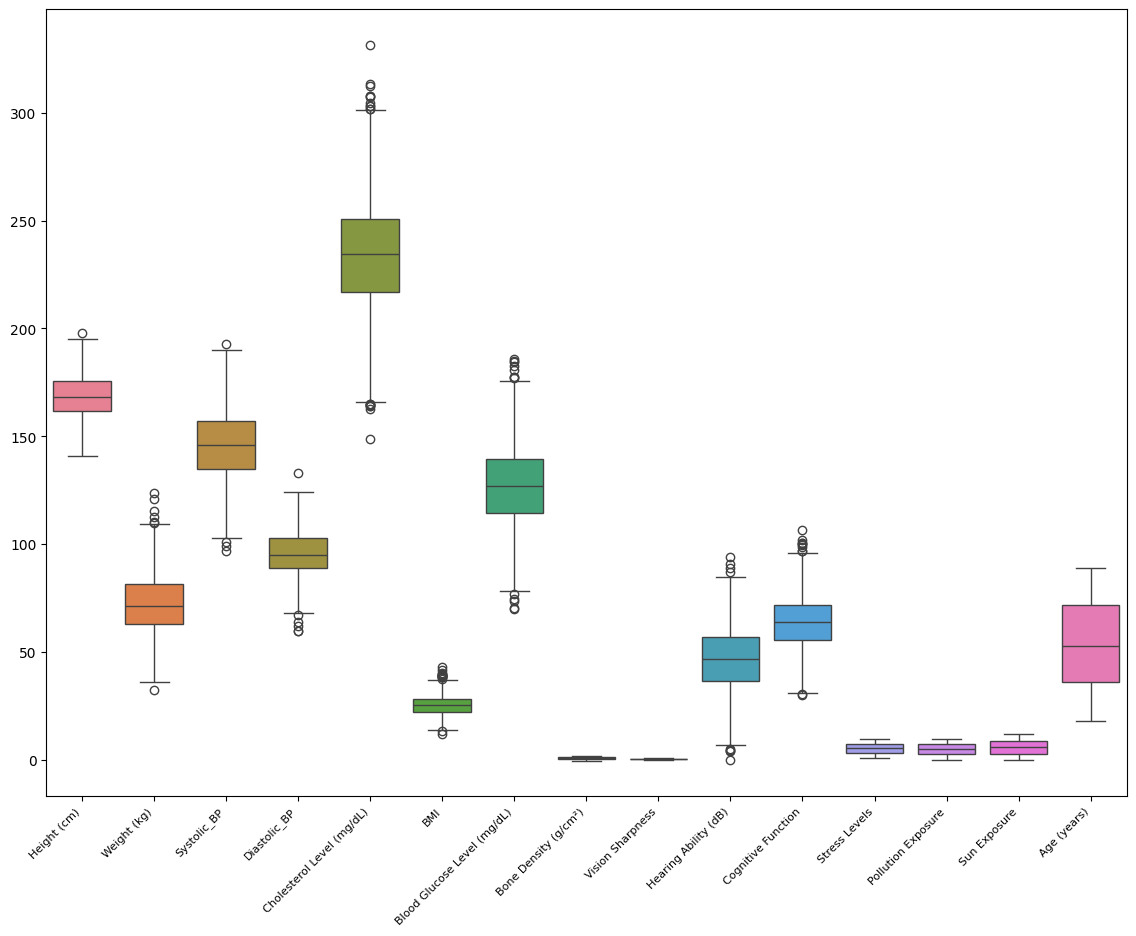

In [ ]:
# View Outliers
plt.figure(figsize=(12, 10))
sns.boxplot(data=df.select_dtypes(include=[np.number]))
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.tight_layout(pad=3)
plt.show()

## Data Exploration

Function for testing features one by one for feature importance and scores.

In [ ]:
# This functions takes in the regular X and y as well as the name of your model
# This function uses your model to get errors

def test_features_individually(X_i, y_i, model):
  #Create an empty Dataset to hold the features and their scores
  each_feature_score = pd.DataFrame({"Feature":[], "R2":[], "RMSE":[]})

  # Go through each feature and create training and testing for that individual one
  #for i in X_i.columns[:4]:
  for i in X_i.columns:
    # Grab only one feature:
    current_dataset = X_i.loc[:,i]
    current_dataset = pd.DataFrame(current_dataset)

    cur_X_train, cur_X_test, cur_y_train, cur_y_test = train_test_split(current_dataset, y_i)

    # Assuming the model returns r2 and mse the model will take the dataset, training x/y and testing x/y
    r2_cur, rmse_cur = model(current_dataset, cur_X_train, cur_y_train, cur_X_test, cur_y_test)

    # Add the feature name, r2, and mse score
    each_feature_score.loc[len(each_feature_score)] = [i, r2_cur, rmse_cur]

  return each_feature_score

## Models

### Neural Network

In [ ]:
def neural_network_tasks():
    """
    Performs all neural network related tasks.

    Returns:
    acceptable_r2_values (list[list[str, int]]): The r2 values that are greater than the acceptable minimum and the name of the corresponding dataset.
    """

    # Train and test models
    acceptable_r2_values = []

    def calc_r2(set_name, feature_train_set, feature_test_set):
      r2 = train_and_test(set_name, feature_train_set, feature_test_set)
      if  r2 > 0.8:
          acceptable_r2_values.append([set_name, r2])

    calc_r2("All", X_train, X_test)

    for ease in ['Easy', 'Moderate', 'Difficult']:
      calc_r2(f"Physical-{ease}", Physical[ease][0], Physical[ease][1])

    calc_r2("Survey", Survey[0], Survey[1])

    calc_r2("Ambiguous", Ambiguous[0], Ambiguous[1])

    return acceptable_r2_values

def train_and_test(set_name, feature_train_set, feature_test_set):
      print(f"Neural Network using {set_name} Features")
      label_set_test = np.array(y_test)
      feature_set_train = np.array(feature_train_set)
      feature_set_test = np.array(feature_test_set)

      neural_network = train_neural_network_model(feature_set_train)
      loss, mae, mse, r2 = neural_network.evaluate(feature_set_test, label_set_test)

      return r2

def train_neural_network_model(nnet_X_train: pd.DataFrame) -> tf.keras.Sequential:
    """
    Trains a sequential neural network.

    Returns:
    model (tensorflow.keras.Sequential): The trained model.
    """

    model = tf.keras.Sequential([
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse', 'r2_score'])
    model.fit(nnet_X_train, np.array(y_train), epochs=50, validation_split=0.2, batch_size=32, verbose=0)

    return model

In [ ]:
nn_acceptable_r2_values = neural_network_tasks()
print("\nAcceptable Subsets (R-Squared value greater than 0.8)")
for pair in nn_acceptable_r2_values:
  print(f"\t{pair[0]}: {pair[1]}")

Neural Network using All Features
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065 - mae: 0.0641 - mse: 0.0065 - r2_score: 0.9246
Neural Network using Physical-Easy Features
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0416 - mae: 0.1642 - mse: 0.0416 - r2_score: 0.5173 
Neural Network using Physical-Moderate Features
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0120 - mae: 0.0880 - mse: 0.0120 - r2_score: 0.8605 
Neural Network using Physical-Difficult Features
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0097 - mae: 0.0787 - mse: 0.0097 - r2_score: 0.8873
Neural Network using Survey Features
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0877 - mae: 0.2531 - mse: 0.0877 - r2_score: -0.0124
Neural Network using Ambiguous Features
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0654 - mae: 0.2125 - mse: 0.0654 - r2_score: 0.2440 

Acceptable Subsets (R-Squared value greater than 0.8)
	All: 0.9264570474624634
	Physical-Moderate: 0.8587254881858826
	Physical-Difficult

Focusing on the subsets that had an R-Squared value greater than 80%, and since Physical-Difficult only has one feature, we will ignore that dataset and filter Physical-Moderate by its most likely contributor and see if we can still get good results.

In [ ]:
Moderate_No_Vision = group_sets([
      'Cholesterol Level (mg/dL)',
      'Blood Glucose Level (mg/dL)',
      'Hearing Ability (dB)',
      'Gender'
    ])

Moderate_No_Hearing = group_sets([
      'Cholesterol Level (mg/dL)',
      'Blood Glucose Level (mg/dL)',
      'Vision Sharpness',
      'Gender'
    ])

Moderate_No_Vision_No_Hearing = group_sets([
      'Cholesterol Level (mg/dL)',
      'Blood Glucose Level (mg/dL)',
      'Gender'
    ])

Only_Vision_and_Gender = group_sets([

      'Gender'
    ])

Only_Hearing_and_Gender = group_sets([
      'Hearing Ability (dB)',
      'Gender'
    ])

Vision_Hearing_and_Gender = group_sets([
      'Vision Sharpness',
      'Hearing Ability (dB)',
      'Gender'
    ])

train_and_test("Physical-Moderate (No Vision)", Moderate_No_Vision[0], Moderate_No_Vision[1])
train_and_test("Physical-Moderate (No Hearing)", Moderate_No_Hearing[0], Moderate_No_Hearing[1])
train_and_test("Physical-Moderate (No Vision, No Hearing)", Moderate_No_Vision_No_Hearing[0], Moderate_No_Vision_No_Hearing[1])
train_and_test("Only Vision", Only_Vision_and_Gender[0], Only_Vision_and_Gender[1])
train_and_test("Only Hearing", Only_Hearing_and_Gender[0], Only_Hearing_and_Gender[1])
train_and_test("Vision and Hearing", Vision_Hearing_and_Gender[0], Vision_Hearing_and_Gender[1])

Neural Network using Physical-Moderate (No Vision) Features
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0390 - mae: 0.1560 - mse: 0.0390 - r2_score: 0.5485 
Neural Network using Physical-Moderate (No Hearing) Features
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0139 - mae: 0.0941 - mse: 0.0139 - r2_score: 0.8391 
Neural Network using Physical-Moderate (No Vision, No Hearing) Features
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0578 - mae: 0.2001 - mse: 0.0578 - r2_score: 0.3308 
Neural Network using Only Vision Features
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0895 - mae: 0.2599 - mse: 0.0895 - r2_score: -0.0347 
Neural Network using Only Hearing Features
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0434 - mae: 0.1685 - mse: 0.0434 - r2_score: 0.4979 
Neural Network using Vision and Hearing Features
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0131 - mae: 0.0909 - mse: 0.0131 - r2_score: 0.8483


0.8501172065734863

### K-Nearest Neighbors (KNN)

In [ ]:
def KNN_model(X_train, X_test, y_train, y_test):
    rmse_val = [] #to store rmse values for different k
    rscore_val = [] #to store r score values for different k
    for K in range(20):
        K = K+1
        model = KNeighborsRegressor(n_neighbors = K)
        model.fit(X_train, y_train)  #fit the model
        pred=model.predict(X_test) #make prediction on test set
        error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
        rmse_val.append(error) #store rmse values
        r2 = r2_score(y_test, pred) #calculate R score
        rscore_val.append(r2) #store r score values

    #plotting the rmse values and rscore values against k values
    curve = pd.DataFrame(rmse_val) #elbow curve
    curve.plot()
    plt.show()
    curve = pd.DataFrame(rscore_val)
    curve.plot()
    plt.show()

    #print the lowest rmse value and its K
    rmse_val = np.array(rmse_val)
    print("Lowest Root Mean Squared Error and its K:")
    print(rmse_val.min())
    print(rmse_val.argmin())

    #print the highest r score value and its K
    rscore_val = np.array(rscore_val)
    print("Highest R Score and its K:")
    print(rscore_val.max())
    print(rscore_val.argmax())

    return model

Using all features:


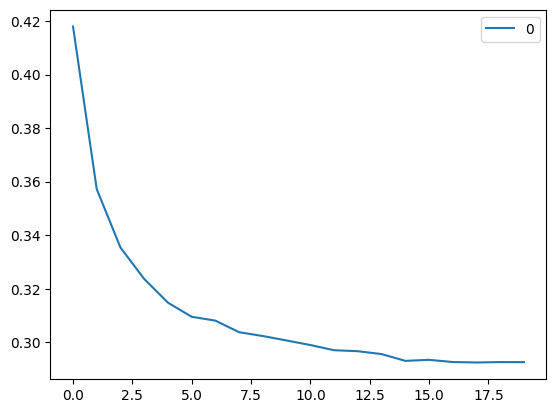

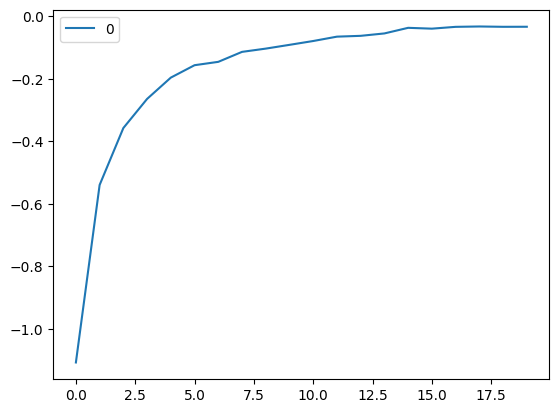

Lowest Root Mean Squared Error and its K:
0.2924982910039157
17
Highest R Score and its K:
-0.03235631134335182
17


In [ ]:
print("Using all features:")
model = KNN_model(X_train, X_test, y_train, y_test)

KNN using only easy to collect features:


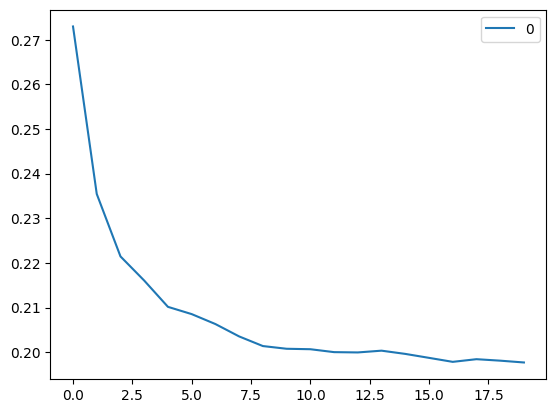

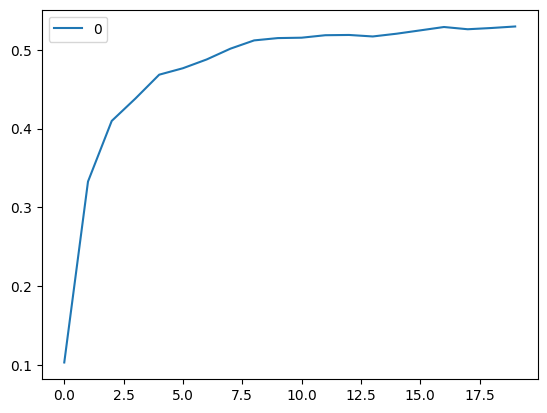

Lowest Root Mean Squared Error and its K:
0.19769416666915818
19
Highest R Score and its K:
0.5295931295092242
19


In [ ]:
print("KNN using only easy to collect features:")
XCorEasy = df_norm[[
    'Height (cm)',
    'Weight (kg)',
    'BMI',
    'Systolic_BP',
    'Diastolic_BP',
    'Gender'
]]
XCorEasy_train, XCorEasy_test, y_train, y_test = train_test_split(XCorEasy, y)
model = KNN_model(XCorEasy_train, XCorEasy_test, y_train, y_test)

KNN using only moderate difficulty to collect features:


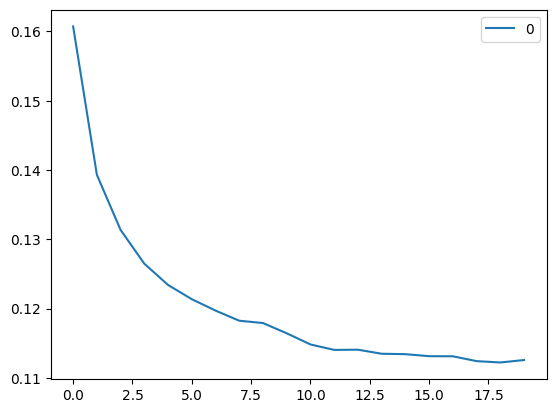

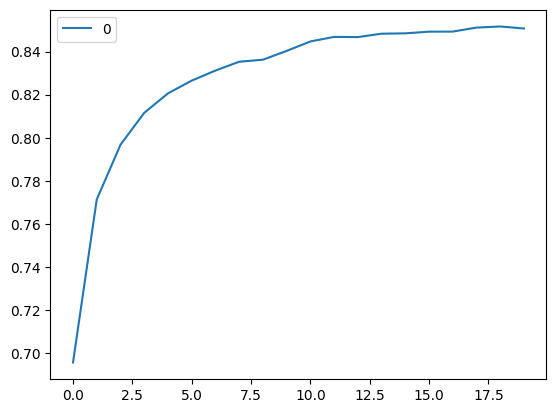

Lowest Root Mean Squared Error and its K:
0.11223705657498917
18
Highest R Score and its K:
0.851625657321258
18


In [ ]:
print("KNN using only moderate difficulty to collect features:")
XCorMod = df_norm[[
    'Cholesterol Level (mg/dL)',
    'Blood Glucose Level (mg/dL)',
    'Hearing Ability (dB)',
    'Vision Sharpness',
    'Gender'
]]
XCorMod_train, XCorMod_test, y_train, y_test = train_test_split(XCorMod, y)
model = KNN_model(XCorMod_train, XCorMod_test, y_train, y_test)

KNN using only difficult to collect features:


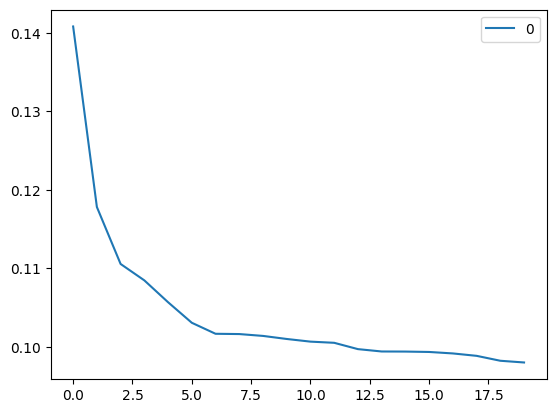

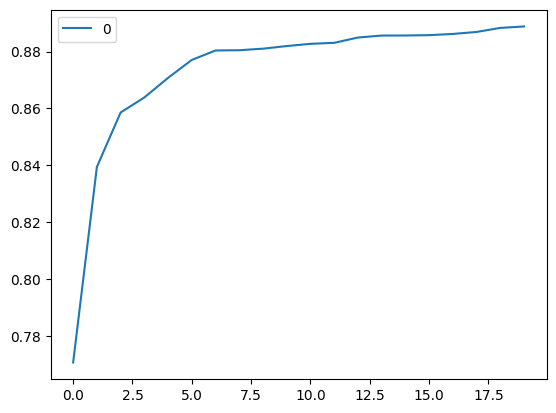

Lowest Root Mean Squared Error and its K:
0.09801564865270589
19
Highest R Score and its K:
0.888849390708976
19


In [ ]:
print("KNN using only difficult to collect features:")
XCorDif = df_norm[['Bone Density (g/cm²)','Gender']]
XCorDif_train, XCorDif_test, y_train, y_test = train_test_split(XCorDif, y)
model = KNN_model(XCorDif_train, XCorDif_test, y_train, y_test)

KNN using only survey features:


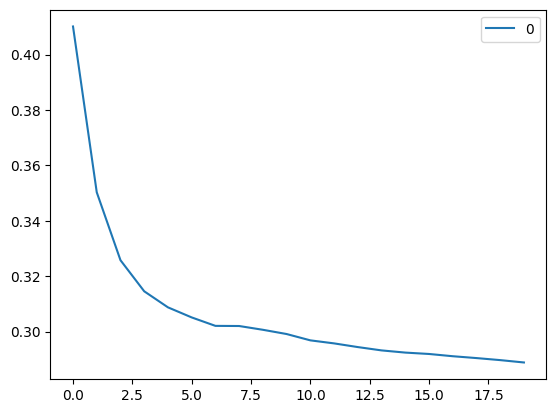

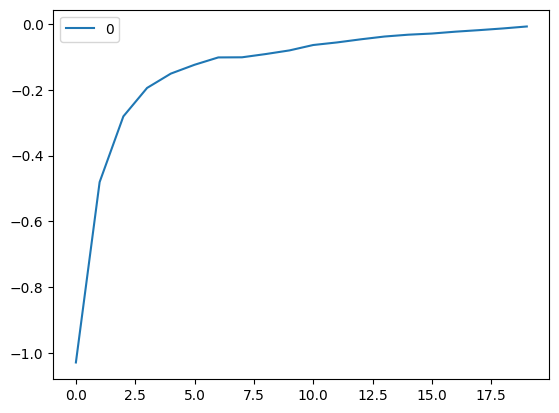

Lowest Root Mean Squared Error and its K:
0.28885514624141645
19
Highest R Score and its K:
-0.006718488014198387
19


In [ ]:
print("KNN using only survey features:")
SurveyFeatures = df_norm[['Physical Activity Level',
    'Smoking Status',
    'Sleep Patterns',
    'Mental Health Status',
    'Stress Levels',
    'Diet',
    'Pollution Exposure',
    'Sun Exposure',
    'Education Level',
    'Alcohol Consumption',
    'Gender']]
SurveyFeatures_train, SurveyFeatures_test, y_train, y_test = train_test_split(SurveyFeatures, y)
model = KNN_model(SurveyFeatures_train, SurveyFeatures_test, y_train, y_test)

KNN using only Ambiguous features:


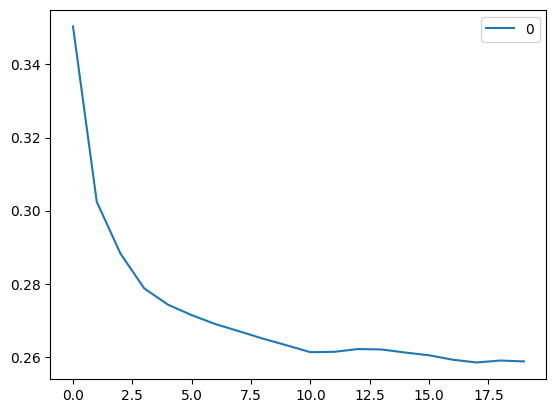

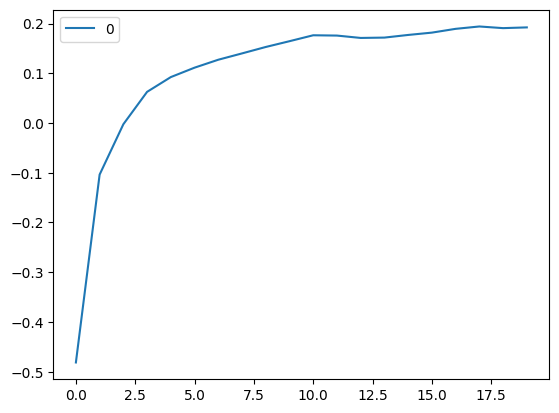

Lowest Root Mean Squared Error and its K:
0.25844155429027704
17
Highest R Score and its K:
0.19405085328736427
17


In [ ]:
print("KNN using only Ambiguous features:")
AmbiguousFeatures = df_norm[[
    'Medication Use',
    'Chronic Diseases',
    'Cognitive Function',
    'Family History',
    'Gender'
]]
AmbiguousFeatures_train, AmbiguousFeatures_test, y_train, y_test = train_test_split(AmbiguousFeatures, y)
model = KNN_model(AmbiguousFeatures_train, AmbiguousFeatures_test, y_train, y_test)

### Linear Regression

In [ ]:
def LinearRegression_model(df_norm):

    X = df_norm.drop(columns=['Age (years)'])
    y = df_norm['Age (years)']
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    print("Linear Regression using all features:")
    model = LinearRegression()
    model.fit(X_train, y_train)
    AllFeatureScore = model.score(X_test, y_test)
    print("Rscore: ", AllFeatureScore)


    print("Linear Regression using only easy to collect features:")
    XCorEasy = df_norm[[
    'Height (cm)',
    'Weight (kg)',
    'BMI',
    'Systolic_BP',
    'Diastolic_BP',
    'Gender'
    ]]
    XCorEasy_train, XCorEasy_test, y_train, y_test = train_test_split(XCorEasy, y)
    model = LinearRegression()
    model.fit(XCorEasy_train, y_train)
    EasyFeatureScore = model.score(XCorEasy_test, y_test)
    print("Rscore: ", EasyFeatureScore)

    print("Linear Regression using only moderate difficulty to collect features:")
    XCorMod = df_norm[[
    'Cholesterol Level (mg/dL)',
    'Blood Glucose Level (mg/dL)',
    'Hearing Ability (dB)',
    'Vision Sharpness',
    'Gender'
    ]]
    XCorMod_train, XCorMod_test, y_train, y_test = train_test_split(XCorMod, y)
    model = LinearRegression()
    model.fit(XCorMod_train, y_train)
    ModerateFeatureScore = model.score(XCorMod_test, y_test)
    print("Rscore: ", ModerateFeatureScore)

    print("Linear Regression using only difficult to collect features:")
    XCorDif = df_norm[['Bone Density (g/cm²)','Gender']]
    XCorDif_train, XCorDif_test, y_train, y_test = train_test_split(XCorDif, y)
    model = LinearRegression()
    model.fit(XCorDif_train, y_train)
    DifficultFeatureScore = model.score(XCorDif_test, y_test)
    print("Rscore: ", DifficultFeatureScore)

    print("Linear Regression using only survey features:")
    SurveyFeatures = df_norm[['Physical Activity Level',
        'Smoking Status',
        'Sleep Patterns',
        'Mental Health Status',
        'Stress Levels',
        'Diet',
        'Pollution Exposure',
        'Sun Exposure',
        'Education Level',
        'Alcohol Consumption',
        'Gender']]
    SurveyFeatures_train, SurveyFeatures_test, y_train, y_test = train_test_split(SurveyFeatures, y)
    model = LinearRegression()
    model.fit(SurveyFeatures_train, y_train)
    SurveyFeatureScore = model.score(SurveyFeatures_test, y_test)
    print("Rscore: ", SurveyFeatureScore)

    print("Linear Regression using only Ambiguous features:")
    AmbiguousFeatures = df_norm[[
        'Medication Use',
        'Chronic Diseases',
        'Cognitive Function',
        'Family History',
        'Gender'
    ]]
    AmbiguousFeatures_train, AmbiguousFeatures_test, y_train, y_test = train_test_split(AmbiguousFeatures, y)
    model = LinearRegression()
    model.fit(AmbiguousFeatures_train, y_train)
    AmbiguousFeatureScore = model.score(AmbiguousFeatures_test, y_test)
    print("Rscore: ", AmbiguousFeatureScore)

    return model

#Run linear regression modles
model = LinearRegression_model(df_norm)

Linear Regression using all features:
Rscore:  0.93702046329942
Linear Regression using only easy to collect features:
Rscore:  0.550564030105624
Linear Regression using only moderate difficulty to collect features:
Rscore:  0.8532481667273403
Linear Regression using only difficult to collect features:
Rscore:  0.8674783227148635
Linear Regression using only survey features:
Rscore:  0.011322698395942354
Linear Regression using only Ambiguous features:
Rscore:  0.289060479127366


The two models being used for univariate training were Random Forest and Support Vector Regression. The experiment was first performed on Random Forest where we tracked every feature and created a data frame to hold the R-Squared and RMSE values.

### Random Forest

When it came to creating the Random Forest model, it was difficult to select hyperparameters right off the bat since terms such as max depth or criterion cannot be easily guessed. However, to counter this, grid search was used to first test a wide range of values for each of the hyperparameters, and from there, more narrow values can be tested.


In [ ]:
def random_forest(X, X_train, y_train, X_test, y_test):

    # Since there are numerous categorical features in our dataset we need to encode them numerically
    # Which is done in the prune_data function
    print("Begin Random Forest Grid Search")

    # Tests different hyperparameters for RandomForestRegressor to see which is best
    param_grid = {
        "n_estimators" : [80, 100, 150],
        "criterion" : ["squared_error", "absolute_error", "poisson"],
        "max_depth" : [3],
        "min_samples_split" : [2, 5, 10],
        "random_state" : [42]
    }

    gs = GridSearchCV(estimator=RandomForestRegressor(),
                  param_grid=param_grid,
                  scoring="r2",
                  refit=True,
                  cv=3,
                  n_jobs=-1)

    #rf = RandomForestRegressor(n_estimators=100, criterion= "squared_error",  n_jobs=-1, random_state=42)

    gs.fit(X_train, y_train)

    print("Random Forest Grid Search Finish")

    predictions = gs.predict(X_test)
    print("Finished with:", gs.best_params_)
    print("R-Squared:", gs.best_score_, "RMSE:", sqrt(mean_squared_error(y_test, predictions)))
    print("\n")

    # Takes the first tree [0]
    rf = gs.best_estimator_
    first_rf = rf.estimators_[0]

    # Plot but only limit to depth of 4 including root
    #tree.plot_tree(first_rf, max_depth=3, feature_names = X_train.columns, filled = True, fontsize=6)

    #plt.savefig("first_rf.png", dpi=900)
    #plt.figure(figsize=(60, 18))
    #plt.tight_layout()
    #plt.show()

    return rf


rf_tree = random_forest(X, X_train, y_train, X_test, y_test)

Begin Random Forest Grid Search
Random Forest Grid Search Finish
Finished with: {'criterion': 'absolute_error', 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 80, 'random_state': 42}
R-Squared: 0.9030793590721243 RMSE: 0.09187356507144324




Once the model finished, it reached a reliable position with an R-squared of .903 and RMSE .091. What was interesting about the model was that the criterion did not have a preference as to whether it was Absolute Error, Poisson, or Squared Error, it seemed almost random. Furthermore, besides the criterion, the model always seemed to gravitate to the same hyperparameters.



Another fascinating observation was seeing the first decision tree:

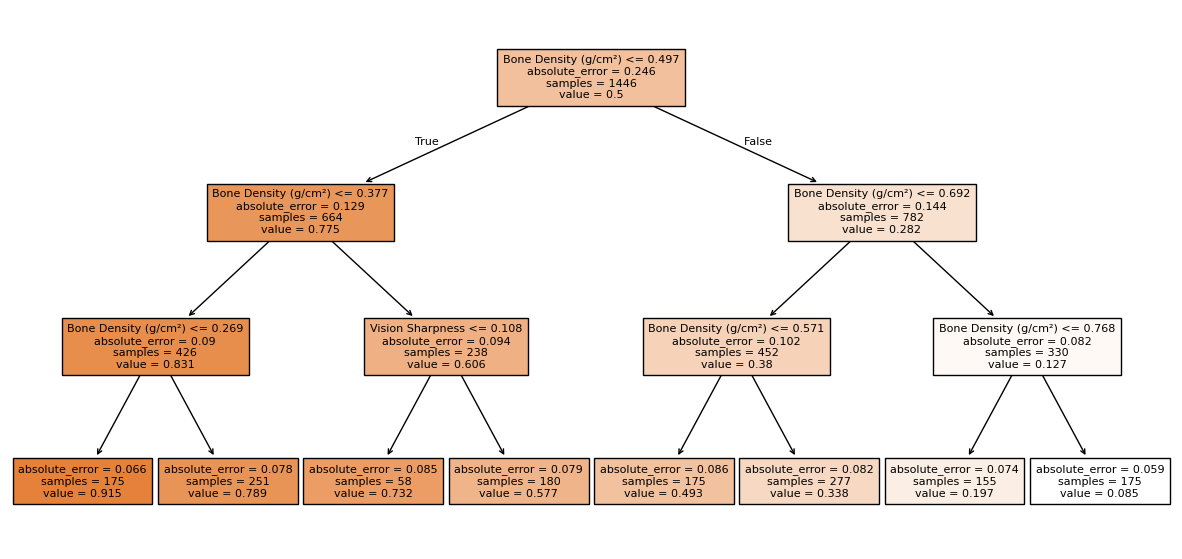

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(15, 7))

first_tree = rf_tree.estimators_[0]

tree.plot_tree(first_tree, feature_names = X_train.columns, filled = True, fontsize=8)
plt.show()
plt.tight_layout()

In this tree, the root takes the feature: Bone Density and splits the branch between .497, from there it splits it again and the only other feature it looks at throughout the entire tree is Vision Sharpness. This speaks volumes to how much the model values each of the features, in this instance, Bone Density comes first, and then Vision Sharpness, all of the other features do not seem to matter much to this regression model.

In [ ]:
# random_forest with narrowed options for gridsearch for faster runtime

def random_forest_minimal(X, X_train, y_train, X_test, y_test):

    # Since there are numerous categorical features in our dataset we need to encode them numerically
    # Which is done in the prune_data function
    #print("Begin Random Forest Grid Search")

    # Tests different hyperparameters for RandomForestRegressor to see which is best
    param_grid = {
        "n_estimators" : [80, 100, 150],
        "criterion" : ["squared_error", "absolute_error", "poisson"],
        "max_depth" : [3],
        "min_samples_split" : [2, 10],
        "random_state" : [42]
    }

    gs = GridSearchCV(estimator=RandomForestRegressor(),
                  param_grid=param_grid,
                  scoring="r2",
                  refit=True,
                  cv=3,
                  n_jobs=-1)


    gs.fit(X_train, y_train)

    predictions = gs.predict(X_test)

    r2 = gs.best_score_
    rmse = sqrt(mean_squared_error(y_test, predictions))

    return r2, rmse

In [ ]:
rf_results =  test_features_individually(X,y,random_forest_minimal)
rf_results

Current feature: Gender
Current feature: Height (cm)
Current feature: Weight (kg)
Current feature: Systolic_BP
Current feature: Diastolic_BP
Current feature: Cholesterol Level (mg/dL)
Current feature: BMI
Current feature: Blood Glucose Level (mg/dL)
Current feature: Bone Density (g/cm²)
Current feature: Vision Sharpness
Current feature: Hearing Ability (dB)
Current feature: Physical Activity Level
Current feature: Smoking Status
Current feature: Alcohol Consumption
Current feature: Diet
Current feature: Chronic Diseases
Current feature: Medication Use
Current feature: Family History
Current feature: Cognitive Function
Current feature: Mental Health Status
Current feature: Sleep Patterns
Current feature: Stress Levels
Current feature: Pollution Exposure
Current feature: Sun Exposure
Current feature: Education Level
Current feature: Income Level


,Feature,R2,RMSE
0,Gender,-0.004760,0.284167
1,Height (cm),-0.005675,0.290294
2,Weight (kg),-0.008186,0.289375
3,Systolic_BP,0.411826,0.218370
4,Diastolic_BP,0.368633,0.228494
5,Cholesterol Level (mg/dL),0.175046,0.266785
6,BMI,-0.005081,0.283887
7,Blood Glucose Level (mg/dL),0.170085,0.262317
8,Bone Density (g/cm²),0.885173,0.102072
9,Vision Sharpness,0.824648,0.127011


The following figure showcases the features ranked based on the two scores:

Text(0.5, 1.0, 'RMSE Score')

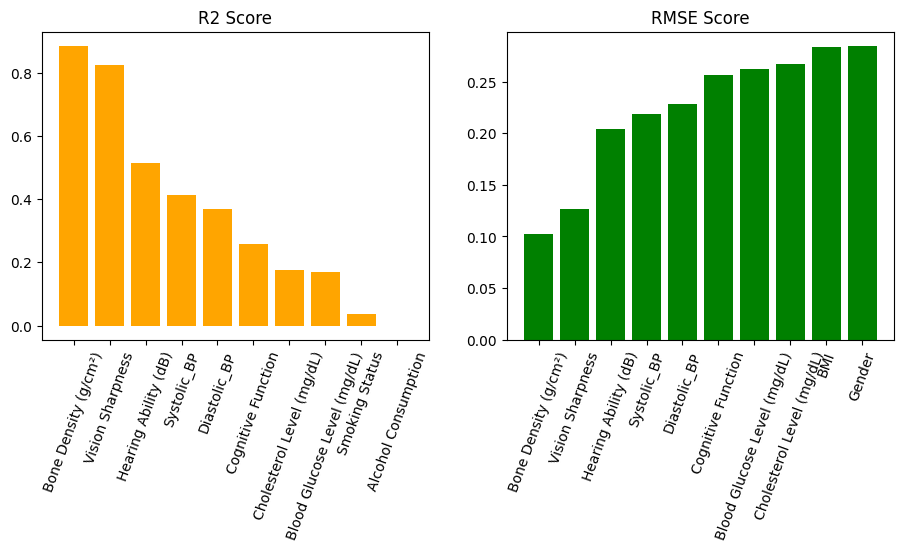

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(11, 4))


sorted_r2 = rf_results.sort_values("R2", ascending = False)[:10]

axs[0].bar(sorted_r2.loc[:, "Feature"], sorted_r2.loc[:, "R2"], color = "orange")
axs[0].set_xticks(sorted_r2.loc[:, "Feature"])
axs[0].set_xticklabels(sorted_r2.loc[:, "Feature"], rotation=70)
axs[0].set_title("R2 Score")



sorted_rmse = rf_results.sort_values("RMSE", ascending = True)[:10]

axs[1].bar(sorted_rmse.loc[:, "Feature"], sorted_rmse.loc[:, "RMSE"], color = "green")
axs[1].set_xticks(sorted_rmse.loc[:, "Feature"])
axs[1].set_xticklabels(sorted_rmse.loc[:, "Feature"], rotation=70)
axs[1].set_title("RMSE Score")

Very similar to the execution with all of the columns, Bone Density and Vision Sharpness take a substantial lead compared to the others in the plots. Furthermore, if we dig deeper into a wider array of the chosen features, we can see that these choices do make sense whenever we consider someone aging; two of the first things we imagine changing are their ability to see and hear, and our model picks up on that. Below is a graphic of all R2 scores

Text(0.5, 1.0, 'All R2 Scores')

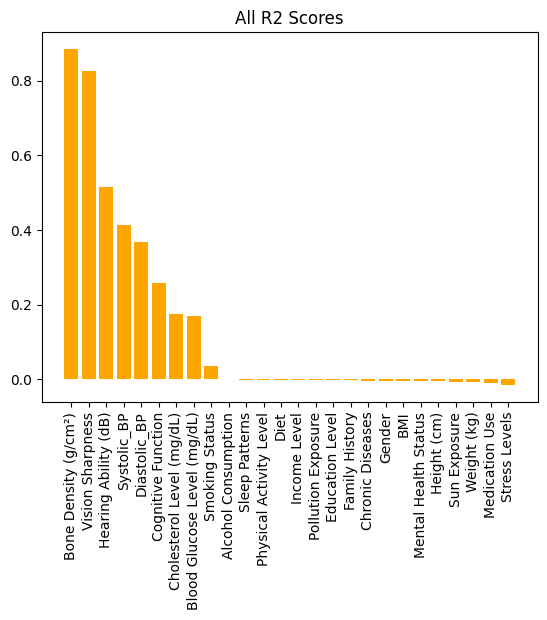

In [ ]:
sorted_r2 = rf_results.sort_values("R2", ascending = False)

plt.bar(sorted_r2.loc[:, "Feature"], sorted_r2.loc[:, "R2"], color = "orange")
plt.xticks(rotation=90)
plt.title("All R2 Scores")

### Support Vector Regression

In [ ]:
def svr(X, X_train, y_train, X_test, y_test):

    print("Begin SVR Grid Search")

    # Using param_grid we were able to test and narrow down to specific ranges of values for the given parameters
    param_grid = {
        "kernel" : ["rbf", "poly"],
        "gamma" : ["scale", "auto", 1, 5, .5],
        "C" : [.8, .9, 1, 5],
        "epsilon" : [.07, .08, .1, .3],
    }

    gs = GridSearchCV(estimator=SVR(),
                  param_grid=param_grid,
                  scoring="r2",
                  refit=True,
                  cv=5,
                  n_jobs=-1)


    gs.fit(X_train, y_train)

    print("SVR Grid Search Finish")

    predictions = gs.predict(X_test)
    print("Finished with:", gs.best_params_)
    print("R-Squared:", gs.best_score_, "RMSE:", sqrt(mean_squared_error(y_test, predictions)))
    print("\n")


svr(X, X_train, y_train, X_test, y_test)

Begin SVR Grid Search
SVR Grid Search Finish
Finished with: {'C': 0.8, 'epsilon': 0.07, 'gamma': 'auto', 'kernel': 'rbf'}
R-Squared: 0.9339033187504879 RMSE: 0.07476995779838638




In [ ]:
# SVR with narrowed options for gridsearch for faster runtime

def svr_minimal(X, X_train, y_train, X_test, y_test):

    #print("Begin SVR Grid Search")

    # Using param_grid we were able to test and narrow down to specific ranges of values for the given parameters
    param_grid = {
        "kernel" : ["rbf"],
        "gamma" : ["auto", 5, .5],
        "C" : [.8, 5],
        "epsilon" : [.1, .3, .7],
    }

    gs = GridSearchCV(estimator=SVR(),
                  param_grid=param_grid,
                  scoring="r2",
                  refit=True,
                  cv=3,
                  n_jobs=-1)


    gs.fit(X_train, y_train)

    predictions = gs.predict(X_test)

    r2 = gs.best_score_
    rmse = sqrt(mean_squared_error(y_test, predictions))

    return r2, rmse

In [ ]:
svr_results =  test_features_individually(X,y,svr_minimal)
svr_results

Current feature: Gender
Current feature: Height (cm)
Current feature: Weight (kg)
Current feature: Systolic_BP
Current feature: Diastolic_BP
Current feature: Cholesterol Level (mg/dL)
Current feature: BMI
Current feature: Blood Glucose Level (mg/dL)
Current feature: Bone Density (g/cm²)
Current feature: Vision Sharpness
Current feature: Hearing Ability (dB)
Current feature: Physical Activity Level
Current feature: Smoking Status
Current feature: Alcohol Consumption
Current feature: Diet
Current feature: Chronic Diseases
Current feature: Medication Use
Current feature: Family History
Current feature: Cognitive Function
Current feature: Mental Health Status
Current feature: Sleep Patterns
Current feature: Stress Levels
Current feature: Pollution Exposure
Current feature: Sun Exposure
Current feature: Education Level
Current feature: Income Level


,Feature,R2,RMSE
0,Gender,0.000244,0.295399
1,Height (cm),-0.001586,0.288123
2,Weight (kg),-0.001068,0.286751
3,Systolic_BP,0.433796,0.225418
4,Diastolic_BP,0.372967,0.227861
5,Cholesterol Level (mg/dL),0.193683,0.268850
6,BMI,-0.000486,0.295883
7,Blood Glucose Level (mg/dL),0.189330,0.269373
8,Bone Density (g/cm²),0.887713,0.098001
9,Vision Sharpness,0.820832,0.123380


The following figure showcases the features ranked based on the two scores:

Text(0.5, 1.0, 'RMSE Score')

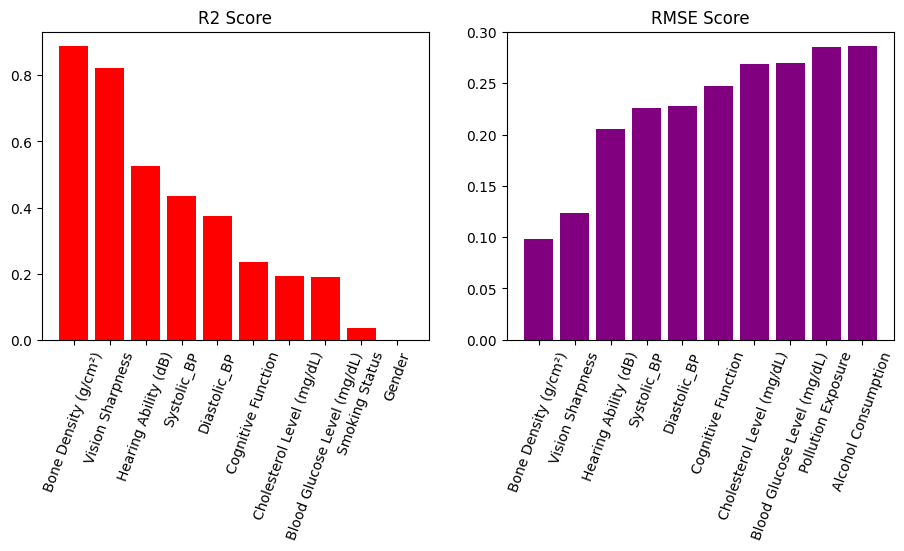

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(11, 4))


sorted_r2 = svr_results.sort_values("R2", ascending = False)[:10]

axs[0].bar(sorted_r2.loc[:, "Feature"], sorted_r2.loc[:, "R2"], color = "red")
axs[0].set_xticks(sorted_r2.loc[:, "Feature"])
axs[0].set_xticklabels(sorted_r2.loc[:, "Feature"], rotation=70)
axs[0].set_title("R2 Score")



sorted_rmse = svr_results.sort_values("RMSE", ascending = True)[:10]

axs[1].bar(sorted_rmse.loc[:, "Feature"], sorted_rmse.loc[:, "RMSE"], color = "purple")
axs[1].set_xticks(sorted_rmse.loc[:, "Feature"])
axs[1].set_xticklabels(sorted_rmse.loc[:, "Feature"], rotation=70)
axs[1].set_title("RMSE Score")

As expected, the output of the SVR is extremely similar to the Random Forest's and for the R-Squared it matches for the first 9 and in the RMSE they match for the first 6 features. Taking a closer look at the R2 plots for each model they have the same first 9 columns but where they differ is with their last columns of Alchohol Consumption and Gender this does not mean that either of the 2 variables are good at assessing Age but actual do the contrary, Alchohol Consumption and Gender have no effect on age whatsoever due their R-Squared score being practically 0, and with the R2 score it can either be positive or negative however, in our data almost no features are shown to have a negative value except for Stress Levels as shown in the Complete R-Squared chart for the Random Forest.

Text(0.5, 1.0, 'All R2 Scores')

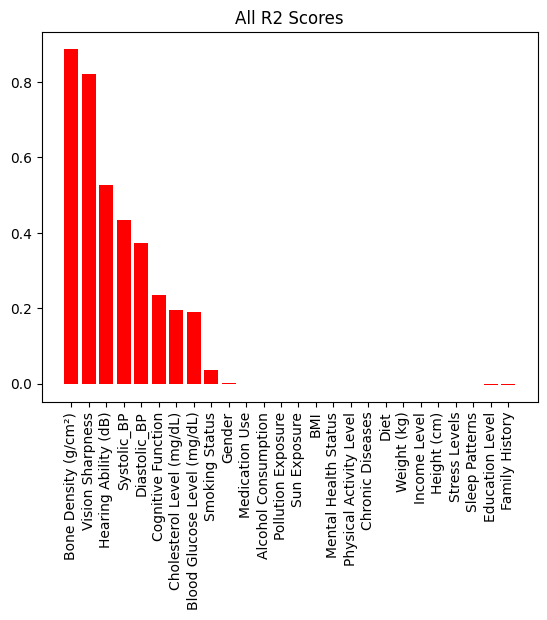

In [ ]:
sorted_r2 = svr_results.sort_values("R2", ascending = False)

plt.bar(sorted_r2.loc[:, "Feature"], sorted_r2.loc[:, "R2"], color = "red")
plt.xticks(rotation=90)
plt.title("All R2 Scores")

For the Decision Tree it will not be trained feature by feature but with the whole dataset, for this experiment we want to confirm what we did above with the univarite training by using the Decision Tree's ability to get feature importances by variance.

### Decision Tree

When it comes to a Decision Tree to produce a continuous value, one of the most efficient ways is to use variance in contrast to entropy, as our inputs and outputs are numbers. The core hyperparameter is the criterion, and if variance minimization is the objective “squared_error” should be chosen for it.

In [ ]:
def decision_tree(X, X_train, y_train, X_test, y_test):
    print("Begin Decision Tree Grid Search")

    # Tests different hyperparameters to see which is best
    param_grid = {
        "criterion" : ["squared_error"], # choose only squared_error for variance reduction
        "splitter" : ["best", "random"],
        "max_depth" : [None, 10, 30],
        "min_samples_split" : [2, 5, 10],
        "min_samples_leaf" : [10, 20, 30, 40],
        "random_state" : [42]
    }

    gs = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  scoring="r2",
                  refit=True,
                  cv=3,
                  n_jobs=-1)


    gs.fit(X_train, y_train)

    print("Decision Tree Grid Search Finish")

    predictions = gs.predict(X_test)
    print("Finished with:", gs.best_params_)
    print("R-Squared:", gs.best_score_, "RMSE:", sqrt(mean_squared_error(y_test, predictions)))
    print("\n")

    # Takes the first tree [0]
    df = gs.best_estimator_


    # Get the feature importances for each of the columns
    importances = gs.best_estimator_.feature_importances_
    df_out = pd.DataFrame({"Features" : X_train.columns, "Importance": importances})
    return df_out, df



In [ ]:
dtree_importances, decision_tree_plot = decision_tree(X, X_train, y_train, X_test, y_test)

Begin Decision Tree Grid Search
Decision Tree Grid Search Finish
Finished with: {'criterion': 'squared_error', 'max_depth': None, 'min_samples_leaf': 40, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}
R-Squared: 0.9035219098722457 RMSE: 0.0870697570709955




Surprisingly, with an R-Squared of .904 and RMSE of .088 a single Decision Tree is slightly more accurate than the Random Forest Regressor. The plot of the decision tree also goes to a depth of 9 unlike the Random Forest, but still agrees that Bone Density should be first and the next important feature is Vision Sharpness. In addition, the features it chooses in the next layers are: (Hearing Ability, Diastolic_BP, Sun Exposure, Smoking Status, and Systolic_BP).

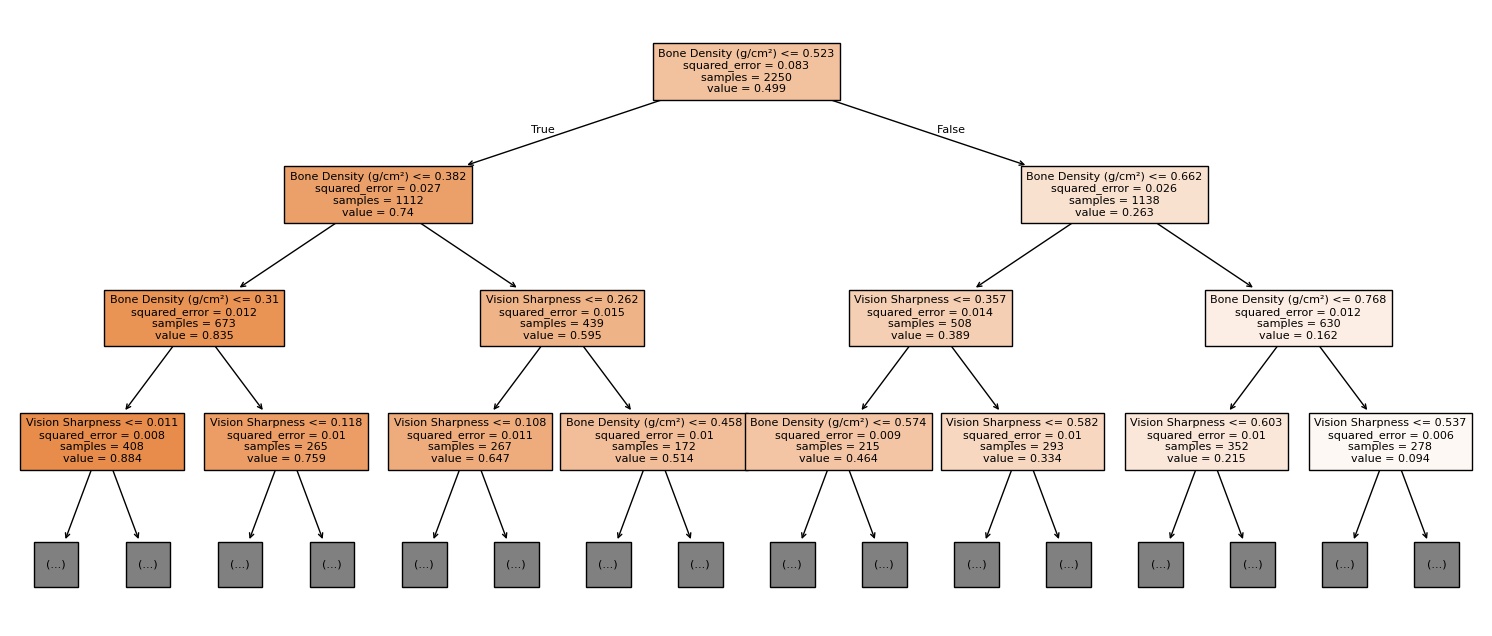

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(19, 8))

# Plot but only limit to depth of 4 including root
tree.plot_tree(decision_tree_plot, max_depth = 3, feature_names = X_train.columns, filled = True, fontsize=8)

plt.show()
plt.tight_layout()
# 9 total depth

In [ ]:
dtree_importances = dtree_importances.sort_values("Importance", ascending = False)
dtree_importances

,Features,Importance
8,Bone Density (g/cm²),0.942960
9,Vision Sharpness,0.046946
10,Hearing Ability (dB),0.006235
4,Diastolic_BP,0.002372
3,Systolic_BP,0.000771
5,Cholesterol Level (mg/dL),0.000440
2,Weight (kg),0.000224
6,BMI,0.000051
22,Pollution Exposure,0.000000
19,Mental Health Status,0.000000


[Text(0, 0, '0.94296'),
 Text(0, 0, '0.0469464'),
 Text(0, 0, '0.00623499'),
 Text(0, 0, '0.00237215'),
 Text(0, 0, '0.00077137')]

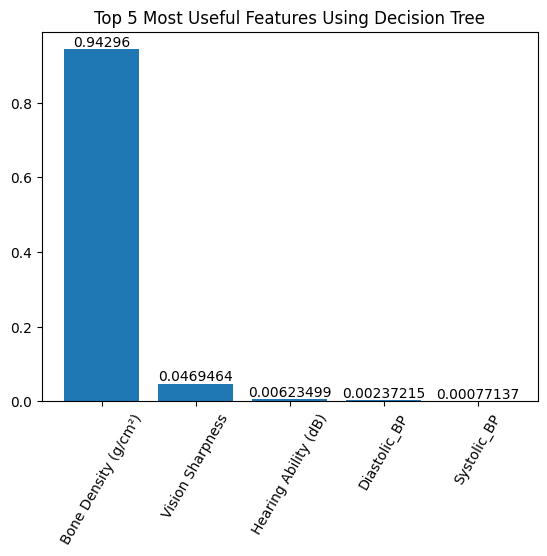

In [ ]:
dtree_importances_x = dtree_importances.loc[:,"Features"][:5]
dtree_importances_y = dtree_importances.loc[:,"Importance"][:5]


fig, axs = plt.subplots()
axs.bar(dtree_importances_x, dtree_importances_y)
axs.set_xticks(dtree_importances_x)
axs.set_xticklabels(dtree_importances_x, rotation=60)
axs.set_title("Top 5 Most Useful Features Using Decision Tree")

axs.bar_label(axs.containers[0], label_type='edge')

Bone Density far outweighs any other feature

## Results

### Neural Network

---

The Neural Network model was capable of consistently achieving R-Squared scores greater than 80% on the Physical-Moderate and Physical-Difficult datasets. When using all features, the R-Squared score was closer to 91% while Physical-Difficult and Physical-Moderate were at about 89% and 85% respectively. Physical-Easy had an R-Squared score of about 50%, while ambiguous and survey were largely unreliable with scores of around 20% and 0% respectively.


> Specific values may change depending on arrangement of input and test data, but all stay within the 84-93% range with All features being the highest, followed by Physical-Difficult and Physical-Moderate.

When further cutting down the Physical-Moderate set to several new datsets, we found that vision sharpness and hearing contributed the most. These features bring predictions above 50% when paired with other Physical-Moderate features, but were ineffective when used individually.



### KNN

---

The K Nearest Neighbor model was best when using the moderate and difficult features. These two feature sets both produced R scores greater than 80%. The moderate features returned a score of 85% and the difficult features returned a score of 89%. This is significantly better than using the other feature sets none of which have greater than 50% other than the easy physical feature set that had a r score of 53%. So based on KNN we can see that we need the moderate difficulty physical features to reach our minimum target r score value.

### Linear Regression

---
Using all the features is what gave the largest R score between all the feature sets at a r score of 94%. The moderate feature set did give a score of 85% and the difficult feature set get a score of 87%. The survey and arbitrary feature sets gave a r score of less than 30% showing we can not depend on them. Using linear regression we can determine that while using all the features and the difficult feature set do give us greater r scores, we can still obtain an acceptable r score by just using the moderate physical features.

### Random Forest Regressor
---
This model finished with an overall R-Squared: 0.903 and RMSE: 0.092. When tested one feature at a time, it was consistent in showing that Bone Density was the strongest factor when predicting someone's age, followed by Vision Sharpness and Hearing Ability. It also portrayed that most of the features in the dataset cannot explain the variance of age well since most of them had an R-Squared of 0 or even slightly negative. In the plot showcasing the scores, the R2 and RMSE plots are very similar to each other, not in values but in what they score. The lower the R2 or the higher the RMSE, the more drastically worse that individual feature predicts age.


###Support Vector Regression
---
The SVR had the second highest overall R-Squared score of .934 and one of the lowest RMSE's of .075. Furthermore, it confirmed the ranking of the features in the Random Forest by classifying the same important features and the same unimportant features. It also managed to recognize the obstructive impact of features with negative R-Squared values and penalized them. This model did exceptionally well in choosing the same hyperparameters each time and was generalized, resulting in performing well in the training and testing data, including all of the features.



### Decision Tree
---

By utilizing the grid search function: .feature_importances_ we were able to see that the Decision Tree follows the same trend as the Random Forest and SVR, although in this situation the Decision Tree ranks Bone Density far higher than Vision Sharpness at .94, which is almost unbelievable how important this feature is, as it far outranks any other piece of data in the whole dataset. In addition to that, with the Decision Tree getting an overall R2 score of .904 and RMSE of .075, which is very solid, it brings up the question of whether or not we need any other features in this dataset since only 12 of the 26 seem to have any importance.

## Conclusions

It seems that the most influential features of a successful age prediction model, defined by an R-Squared score greater than 80%, will be bone density, vision sharpness, and hearing ability (depending on the model). Of the Physical values that are considered easy to collect, blood pressure provided the best predictions with R-Sqaured scores greater than 50%. The Survey and Ambiguous subsets were largely unable to be used as the sole metrics for predicting age.


> It seems that with some models, specifically neural networks, vision sharpness and hearing ability will fail when not paired with each other or some other features from the Physical subsets.



The results seem to be in-line with general intuition, where data collected via physical examinations like bone density and vision sharpness will yield greater results and data collection relying on surveys were not reliable.

##Additions and Improvements to Kaggle Contributions

###General Improvments

Our idea to split the data in multiple ways was not thought of on Kaggle, and by exploring this area we were able to find what are the most important characteristics of our dataset. Creating subsets of: Collection, difficulty mehtod, most correlated features, and grouping one by one, allowed us to get insight as to what really mattered when it came to predicting age.

###Specific Improvments

https://www.kaggle.com/code/dharinesh/getting-started-eda-models-on-human-age-dataset#Training-

https://www.kaggle.com/code/salmarashwan/age-prediction-ml-dl-and-visualization-techniqu#Random-Forest-Regressor**

https://www.kaggle.com/code/mahmoudweso/human-age-prediction#Training-Data


https://www.kaggle.com/code/godoistvan/eda-and-6-models-optimized


### Neural Network


There were not many experiments that used the neural network for the prediction, and the ones that did decided not to expand upon the results to find which features could reliably determine a person's age. In this experiment, we were able to find that the biggest contributors to the neural network model were the Physical-Moderate and Physical-Difficult subsets, but without the hearing or vision features, the Physical-Moderate could not provide enough information for the Neural Network to make accurate predictions.

---

### KNN
There were no notebooks that implemented KNN as it is a simple model. The results we got acceptable R scores when using the moderate difficulty features and difficult features.

---



### Linear Regression

The main improvement we made from the Kaggle reports was that we had some feature selection when working on our linear regression model. Particularly we got acceptable results when using the moderate and difficult features while using less data than other notebooks that use all features.

---

### Random Forest Regressor

There are a few notebooks using this model, but it seems that it is more popular to discretize age into different groups and then use a Forest Classifier, however, in the times when the regressor is used, they add minimal hyperparameters to it, such as random_state or n_estimators, and most of the time, actually, they have a slightly better R2 score compared to ours, but for the RMSE, in most cases we had a better loss. This could be due to our model overfitting as explained by the better loss. Using Grid Search helped tremendously in narrowing down what inputs should be used for the hyperparameters, but in the end they do not need to be perfect but should be robust and be able to give the best accuracy over loss.

---

### Support Vector Regression

Much like Random Forest, the contributors used the classifier version of this algorithm, and when they used SVR, only the bare minimum of hyperparameters were chosen or the default. For our experiments we used Grid Search and got significantly better results in R2 and in the RMSE scores. Moreover, the main goal of using Grid Search was to explore the data and see what hyperparameters the model did best on, and from there, pick closer numbers to the chosen numbers, which could be used to get a better fit.

---

### Decision Tree Regressor

The main purpose of using this algorithm was to leverage its ability to find the best features of a model, but in turn, the accuracy of the test set was quite good and was even better than the Random Forest's. Comparing our results to others, the grid search helped a lot, and we achieved better results for the R2 and RMSE scores, but we did notice that it was not as good as the Random Forest in the contributions themselves, and in most of them they decided not to use a Decision Tree. Overall we noticed that there was not a strong determination to optimize these models in the notebooks but to explore and experiment with them.

---




## Specific Member Contributions

---

### Xavier Garay
* Data importing, preprocessing, pruning, and visualization
* Neural Network Model

### Daniel Cwynar
* Univariate training/testing
* Random Forest, Support Vector Regression, and Decision Tree Models

### Aaron Samuel
* Linear Regression, K Nearest Neighbor

### Team
* Results
* Conclusions
* Additions and Improvements to Kaggle Contributions